In [4007]:
# %reload_ext autoreload
# %autoreload 1   
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pytorch_models
import imp
imp.reload(pytorch_models)
import torchaudio
import torchaudio as ta
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa.display
import os, random


SR=48000
#transformation

spec=ta.functional.spectrogram

def getRandAud():
    classes=os.listdir("./dk_data/")
    rand_class=random.choice(classes)
#     rand_class="stacks"
    rand_sample=random.choice(os.listdir("./dk_data/%s/"%(rand_class,)))

    return "./dk_data/"+rand_class+"/"+rand_sample
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

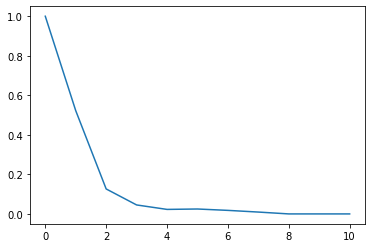

./dk_data/tom_high/Roland_R-8-R8Tom09.wav


In [4010]:
#get freq feats
num_mels=10
ampT=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=80)
melEnv=torchaudio.transforms.MelScale(n_mels=2*num_mels, sample_rate=SR, f_min=0.0, f_max=None, n_stft=None)
PATH_AUDIO=getRandAud()
og_w, sample_rate = torchaudio.load(PATH_AUDIO)  # load tensor from file
wf= ta.transforms.Resample(sample_rate,SR).forward(og_w)
wf=wf[0:SR//4]
wf=wf[:,0:15000]
# plt.plot(wf[0])
num_bins=2000

# spec(wf, pad, window, n_fft, hop_length, win_length, power, normalized)
win_length=num_bins
window=torch.tensor([1]*win_length)
s=spec(wf, 0, window, num_bins, win_length, win_length,2,normalized=False)
s=melEnv(s)

env=s.sum(axis=0).sum(axis=0)
env=env/env.abs().max()
env[torch.isnan(env)]=0

env_vec=torch.cat([env.detach(),torch.zeros(num_mels+1-env.shape[0])],dim=0)
plt.plot(env_vec)

plt.show()
print(PATH_AUDIO)
Audio(wf,rate=SR, autoplay=True)

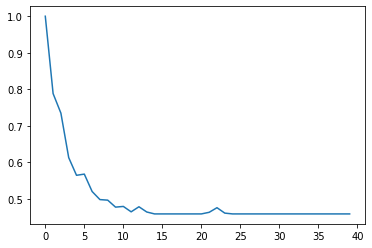

torch.Size([40])
./dk_data/kick/Roland_Tr-909-TR-909Tom_Low_02.wav


In [4037]:
#get freq feats
num_mels=40
ampT=torchaudio.transforms.AmplitudeToDB(stype='magnitude', top_db=80)
mel=torchaudio.transforms.MelScale(n_mels=num_mels, sample_rate=SR, f_min=0.0, f_max=None, n_stft=None)
PATH_AUDIO=getRandAud()
og_w, sample_rate = torchaudio.load(PATH_AUDIO)  # load tensor from file
wf= ta.transforms.Resample(sample_rate,SR).forward(og_w)
wf=wf[:,0:15000]
num_bins=wf[0].shape[0]
win_length=num_bins
window=torch.tensor([1]*win_length)
s=spec(wf, 0, window, num_bins, win_length, win_length,2,normalized=False)
s=mel(s)
s=ampT(s)
env=s.sum(axis=0).sum(axis=1)
env=env/env.abs().max()
env[torch.isnan(env)]=0

plt.plot(env.detach())

plt.show()
print(env.shape)
print(PATH_AUDIO)
Audio(wf,rate=SR, autoplay=True)


In [4039]:
TRAIN_DATA_PATH = "./lstm_data/simple/train"
TEST_DATA_PATH = "./lstm_data/simple/test"
TRANSFORM_IMG = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_loader  = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader=test_loader

classes=list(train_data.class_to_idx.keys()) #get list of classes
print(classes,len(classes))

NameError: name 'BATCH_SIZE' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


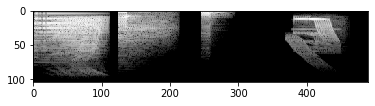

GroundTruth:  stacks        snare         kick        stacks


In [260]:
dataiter = iter(test_loader)
# functions to show an image
def imshow(img):
    img = img      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', '        '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))


In [ ]:
batch_size = 4
n_iters = 3000
num_epochs = n_iters 
num_epochs = int(num_epochs)

'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 120
hidden_dim = 200
layer_dim = 2  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 5
# Number of steps to unroll
seq_dim = 100

model = LSTM2(input_dim, hidden_dim, layer_dim, output_dim)

# JUST PRINTING MODEL & PARAMETERS 
# print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()

'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as Variable
        images = images.view(-1, seq_dim, input_dim).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)

        print(predicted, labels)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Load images to a Torch Variable
                images = images.view(-1, seq_dim, input_dim).requires_grad_()

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))